<a href="https://colab.research.google.com/github/yishengli/GraphMiningNotebooks/blob/master/Gomez_Li_Assignment3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python-igraph

     |████████████████████████████████| 3.2 MB 5.4 MB/s 


In [ ]:
pip install plfit

     |████████████████████████████████| 193 kB 5.4 MB/s 
  Created wheel for plfit: filename=plfit-1.0.3-cp37-cp37m-linux_x86_64.whl size=123178 sha256=8ff3a7f57e06a746dd0b782e1be75b5845ff4a3d169caa962545311c775107a7
  Stored in directory: /root/.cache/pip/wheels/44/c5/30/2761386f6aea1d7ca4ffb706f90535faa81365be034b32055a
Successfully built plfit


In [ ]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
datadir = 'https://raw.githubusercontent.com/ftheberge/GraphMiningNotebooks/master/Datasets/'

In [ ]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [ ]:
## compute several centrality measures - weighted graphs
def centrality_measures_w(g):
    C = pd.DataFrame({'name':g.vs()['name'],\
                      'degree':degree_centrality(g,weights='normalized_weight'),\
                      'pagerank':g.pagerank(weights='weight'),'authority':g.authority_score(weights='weight'),\
                      'hub':g.hub_score(weights='weight'),'between':g.betweenness(),\
                      'closeness':g.closeness()})
    ## normalize betweenness
    n = g.vcount()
    C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
    return C

# Problem 1

Below is the code to read dataset and create graph (copied from the jupiter notebook provided):

In [ ]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

In [ ]:
## define colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [ ]:
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
df = A.head()
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


Subgraph is created for all nodes from the state of New York. Also isolated vertices and loops are removed:

In [ ]:
## Build smaller subgraph for New York
hva = [v for v in g.vs() if v['state'] == 'NY']
G = g.subgraph(hva)

## drop isolated vertices (i.e. without in-state connections)
G = G.subgraph([v for v in G.vs() if v.degree()>0])

## remove loops
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')

13 nodes and 50 directed edges


In [ ]:
## compute normalized weights 
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

Now, the top five ranked airports (with respect to the degree centrality)
in the state of New York are:

NOTE: Results are presented in the same way as Table 3.3 from the Course Textbook.

In [ ]:
## sort w.r.t. degree centrality, look at top airports
C = centrality_measures(G)
Cs = C.sort_values(by='degree', ascending=False)
df = Cs.head(5)
df

,name,degree,pagerank,authority,hub,between,closeness
0,JFK,0.173125,0.342720,1.000000,0.373760,0.647727,0.705882
2,BUF,0.101629,0.195702,0.261299,1.000000,0.167929,0.705882
4,ROC,0.054908,0.109433,0.141841,0.546989,0.000000,0.631579
5,SYR,0.044959,0.097118,0.113975,0.459400,0.243687,0.750000
1,LGA,0.040011,0.108312,0.213367,0.078989,0.286616,0.750000


# Problem 2

Note: We tried two different approaches, as we were not sure which one might be more appropriate. Apologize for the lengthy results. 

In [ ]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [ ]:
## power law graph
gamma = 2.5
##n = 10000
n = 1000
## min and max degrees
delta = 100
Delta = np.sqrt(n)

deg = [delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)) for i in np.arange(1,n+1)]
# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation

In [ ]:
# deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
# g1 = ig.Graph.TupleList(tpl)
g1 = ig.Graph.TupleList(tpl, directed=True)
## number of isolated nodes (no edges)
g1.es['weight'] = deg
iso = n-g1.vcount()
# print('isolates:',iso)

In [ ]:
deg = g1.degree()
g1.vs()['deg'] = deg
K = np.arange(np.min(deg),np.max(deg),1)
auth_score = g1.authority_score()
hub_score = g1.hub_score()
dc = []
pr = []
auth = []
hub = []
bet = []
clo = []
for k in K:
    nodes = [v for v in g1.vs() if v['deg'] == k]
    if len(nodes) > 0:
        dc.append(k/(n-1))
        pr.append(np.mean(g1.pagerank(vertices = nodes)))
        bet.append(np.mean(g1.betweenness(vertices = nodes)))
        clo.append(np.mean(g1.closeness(vertices = nodes)))
        a = []
        h = []
        for n1 in nodes:
            a.append(auth_score[n1.index])
            h.append(hub_score[n1.index])
        auth.append(np.mean(a))
        hub.append(np.mean(h))
    else:
        dc.append(np.nan)
        pr.append(np.nan)
        bet.append(np.nan)
        clo.append(np.nan)
        auth.append(np.nan)
        hub.append(np.nan)
## normalize betweenness
bet = [2*x/((n-1)*(n-2)) for x in bet]

Approach 1

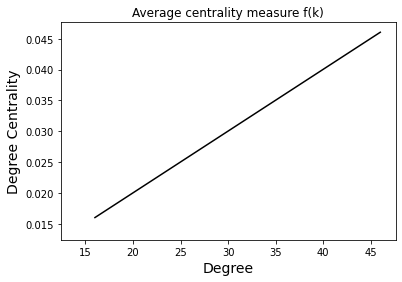

In [ ]:
plt.plot(K,dc,color='black')
plt.title('Average centrality measure f(k)')
plt.xlabel(r'Degree',fontsize=14)
plt.ylabel('Degree Centrality',fontsize=14);

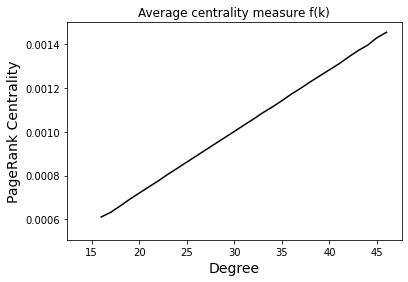

In [ ]:
plt.plot(K,pr,color='black')
plt.title('Average centrality measure f(k)')
plt.xlabel(r'Degree',fontsize=14)
plt.ylabel('PageRank Centrality',fontsize=14);

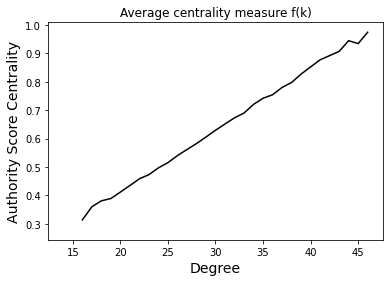

In [ ]:
plt.plot(K,auth,color='black')
plt.title('Average centrality measure f(k)')
plt.xlabel(r'Degree',fontsize=14)
plt.ylabel('Authority Score Centrality',fontsize=14);

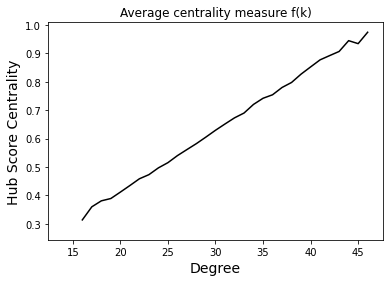

In [ ]:
plt.plot(K,hub,color='black')
plt.title('Average centrality measure f(k)')
plt.xlabel(r'Degree',fontsize=14)
plt.ylabel('Hub Score Centrality',fontsize=14);

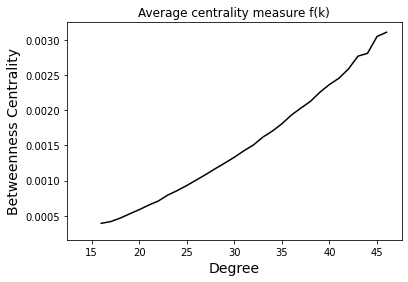

In [ ]:
plt.plot(K,bet,color='black')
plt.title('Average centrality measure f(k)')
plt.xlabel(r'Degree',fontsize=14)
plt.ylabel('Betweenness Centrality',fontsize=14);

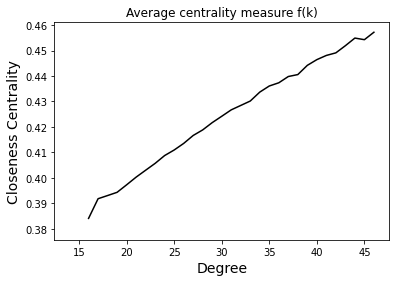

In [ ]:
plt.plot(K,clo,color='black')
plt.title('Average centrality measure f(k)')
plt.xlabel(r'Degree',fontsize=14)
plt.ylabel('Closeness Centrality',fontsize=14);

betweenness:  [0.0002982568817002157, nan, 0.0003918079318421094, 0.0004166563999248178, 0.000466125159511795, 0.0005270143792580978, 0.0005860373893532493, 0.0006512121273309131, 0.0007084616605551178, 0.0007930142973740537, 0.0008577716684313492, 0.0009293895295747115, 0.001007186699058472, 0.001085989512034391, 0.0011691697599076998, 0.0012486652722967504, 0.0013311758717174079, 0.0014226252947532984, 0.0015049050454333185, 0.0016172770725493672, 0.001702960958063068, 0.0018068718730776254, 0.0019306629321083335, 0.0020299685290170242, 0.0021251712071857724, 0.0022555112477091657, 0.0023644880038713786, 0.0024540879270955273, 0.00258617693056365, 0.0027680277667340098, 0.0028077838887805356, 0.0030464475640347784, 0.0031073282975790264]
hub score:  [0.47908798724304885, 0.6087299208994944, 0.4288261138978677, 0.8263720069006207, 0.5114812407231676, 0.5918666959964838, 0.41979654044398246, 0.647276975350432, 0.581257607495252, 0.7508874169892136, 0.5570781977848875, 0.632130254168457

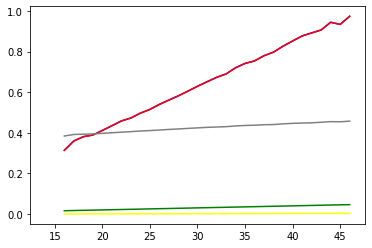

In [ ]:
plt.plot(K,auth,color='blue')
plt.plot(K,hub,color='red')
plt.plot(K,bet,color='yellow')
plt.plot(K,clo,color='grey')
plt.plot(K,dc,color='green')
print('betweenness: ', bet)
print('hub score: ', hub_score)
print('authority score: ', auth_score)
print('closeness: ', clo)
print('pagerank: ', pr)
print('degree centrality: ', dc)

Approach 2

In [ ]:
## compute normalized weights 
## weight is the traffic for airport
mw = np.max(g1.es['weight'])
g1.es()['normalized_weight'] = [w/mw for w in g1.es()['weight']]

In [ ]:
## compute several centrality measures
df = pd.DataFrame({'name':g1.vs()['name'],\
                  'degree':degree_centrality(g1,weights='normalized_weight'),\
                  'pagerank':g1.pagerank(weights='weight'),\
                  'authority':g1.authority_score(weights='weight'),\
                  'hub':g1.hub_score(weights='weight'),\
                  'between':g1.betweenness(),\
                  'closeness':g1.closeness()})

## normalize betweenness
n = g1.vcount()
df['normalized_between'] = [2*x/((n-1)*(n-2)) for x in df['between']]

## sort w.r.t. degree centrality
df = df.sort_values(by='degree', ascending=False)
deg = g1.degree()
df1 = pd.DataFrame(deg)
df1['deg'] = df1[0]
df1['name'] = g1.vs()['name']
del df1[0]

df2 = df1.merge(df)
df2 = df2.groupby('deg').agg({"degree":'mean',"pagerank":'mean','authority': 'mean','hub': 'mean', 'between': 'mean', 'closeness': 'mean' }).reset_index()

Text(0.5, 1.0, 'Correlation between degree and closeness')

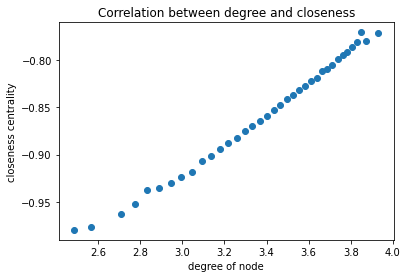

In [ ]:
plt.scatter(np.log(df2['deg']),np.log(df2['closeness']))
plt.xlabel("degree of node")
plt.ylabel("closeness centrality")
plt.title("Correlation between degree and closeness")

Text(0.5, 1.0, 'Correlation between degree and pagerank')

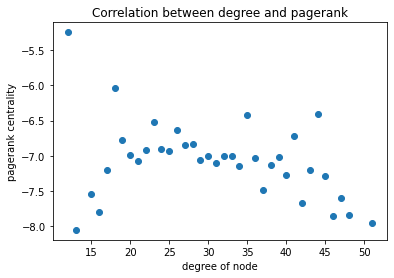

In [ ]:
plt.scatter(df2['deg'],np.log(df2['pagerank']))
plt.xlabel("degree of node")
plt.ylabel("pagerank centrality")
plt.title("Correlation between degree and pagerank")

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Correlation between degree and betweenness')

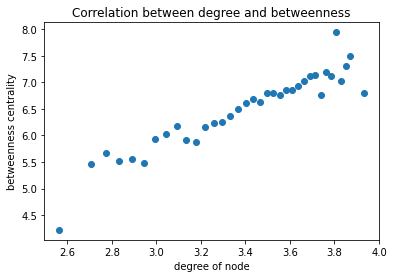

In [ ]:
plt.scatter(np.log(df2['deg']),np.log(df2['between']))
plt.xlabel("degree of node")
plt.ylabel("betweenness centrality")
plt.title("Correlation between degree and betweenness")

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Correlation between degree and Hub')

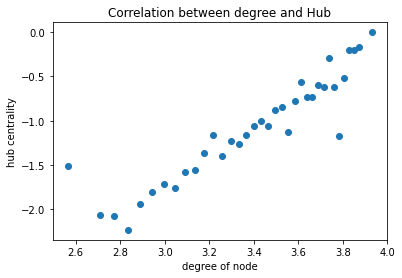

In [ ]:
plt.scatter(np.log(df2['deg']),np.log(df2['hub']))
plt.xlabel("degree of node")
plt.ylabel("hub centrality")
plt.title("Correlation between degree and Hub")

Text(0.5, 1.0, 'Correlation between degree and authority')

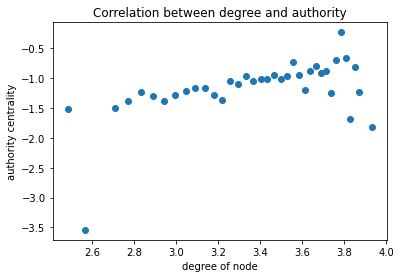

In [ ]:
plt.scatter(np.log(df2['deg']),np.log(df2['authority']))
plt.xlabel("degree of node")
plt.ylabel("authority centrality")
plt.title("Correlation between degree and authority")

Text(0.5, 1.0, 'Correlation between degree and degree centrality')

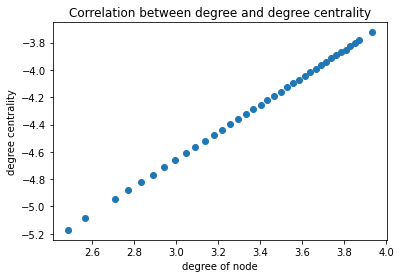

In [ ]:
plt.scatter(np.log(df2['deg']),np.log(df2['degree']))
plt.xlabel("degree of node")
plt.ylabel("degree centrality")
plt.title("Correlation between degree and degree centrality")

# Problem 3

Code to read dataset and generate graph (based on the lecture notebook provided):

In [ ]:
## define colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [ ]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

In [ ]:
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
df = A.head()
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


Code to remove the two nodes that make the graph not weakly connected: 

In [ ]:
## graph is weakly connected except for 2 airports
cl = g.clusters(mode='WEAK').membership
nodes = []
for i in range(g.vcount()):
    if cl[i]>0:
        ##print(i, g.vs[i])
        nodes.append(g.vs[i].index)
## Removing the two nodes to make graph weakly connected
g.delete_vertices(nodes)
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

462 nodes and 11999 directed edges


Below, we calculate the different centrality measures for each node:

In [ ]:
## compute normalized weights 
mw = np.max(g.es['weight'])
g.es()['normalized_weight'] = [w/mw for w in g.es()['weight']]

## compute several centrality measures
matrix = centrality_measures_w(g)
matrix.head(5)

,name,degree,pagerank,authority,hub,between,closeness
0,SFO,0.019337,0.017986,0.572323,0.574479,0.035074,0.544917
1,LAX,0.029707,0.026628,0.765373,0.768892,0.051678,0.559466
2,MCO,0.021867,0.019390,0.564857,0.565243,0.028187,0.551435
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308
4,JFK,0.016892,0.014496,0.445176,0.446092,0.011916,0.532333


The function below help us eliminate nodes based on centrality measure, and ascending/descending criteria. We will use it to review the effectiveness of each centrality measure at making the graph no longer weakly connected:

In [ ]:
def weak_exp(g, matrix, measure, ascending):
    print('Degree centrality measure: ', measure, " | Ascending : ", ascending)
    clusters = g.clusters(mode='WEAK')
    df = matrix.sort_values(by = measure, ascending = ascending)
    df = df.reset_index(drop=True)
    nodes_temp = []
    if (len(clusters) == 1):
        i = 0
        g_temp = g.copy()
        while (len(clusters) == 1):
            airport = df['name'][i]
            node = [v for v in g_temp.vs() if v['name'] == airport]
            g_temp.delete_vertices(node)
            nodes_temp.append([airport, df[measure][i]])
            clusters = g_temp.clusters(mode='WEAK')
            i += 1
        print('Number of nodes removed before graph is no longer weakly connected: ', len(nodes_temp))
        ##print(nodes_temp)
    else:
        print('Graph not weakly connected')
    return nodes_temp

Now, we use the function from the above statement, to calculate the how many number of nodes with the largest/smallest score it takes to make the graph no longer weakly connected: 

In [ ]:
## Comparison matrix
comp = [];
## Degree centrality
deg_des = weak_exp(g, matrix, 'degree', False)
deg_asc= weak_exp(g, matrix, 'degree', True)
comp.append(['Degree Centrality', len(deg_des), len(deg_asc), len(deg_des)/len(deg_asc)])
print('########################################################################')
## PageRank centrality
pr_des = weak_exp(g, matrix, 'pagerank', False)
pr_asc = weak_exp(g, matrix, 'pagerank', True)
comp.append(['PageRank Centrality', len(pr_des), len(pr_asc), len(pr_des)/len(pr_asc)])
print('########################################################################')
## Authority centrality
aut_des = weak_exp(g, matrix, 'authority', False)
aut_asc = weak_exp(g, matrix, 'authority', True)
comp.append(['Authority Centrality', len(aut_des), len(aut_asc), len(aut_des)/len(aut_asc)])
print('########################################################################')
## Hub Centrality
hub_des = weak_exp(g, matrix, 'hub', False)
hub_asc = weak_exp(g, matrix, 'hub', True)
comp.append(['Hub Centrality', len(hub_des), len(hub_asc), len(hub_des)/len(hub_asc)])
print('########################################################################')
## Betweenness centrality
bet_des = weak_exp(g, matrix, 'between', False)
bet_asc = weak_exp(g, matrix, 'between', True)
comp.append(['Betweenness Centrality', len(bet_des), len(bet_asc), len(bet_des)/len(bet_asc)])
print('########################################################################')
## Closeness centrality
clo_des = weak_exp(g, matrix, 'closeness', False)
clo_asc = weak_exp(g, matrix, 'closeness', True)
comp.append(['Closeness Centrality', len(clo_des), len(clo_asc), len(clo_des)/len(clo_asc)])
print('########################################################################')

Degree centrality measure:  degree  | Ascending :  False
Number of nodes removed before graph is no longer weakly connected:  2
Degree centrality measure:  degree  | Ascending :  True
Number of nodes removed before graph is no longer weakly connected:  179
########################################################################
Degree centrality measure:  pagerank  | Ascending :  False
Number of nodes removed before graph is no longer weakly connected:  2
Degree centrality measure:  pagerank  | Ascending :  True
Number of nodes removed before graph is no longer weakly connected:  36
########################################################################
Degree centrality measure:  authority  | Ascending :  False
Number of nodes removed before graph is no longer weakly connected:  2
Degree centrality measure:  authority  | Ascending :  True
Number of nodes removed before graph is no longer weakly connected:  6
########################################################################
Deg

In [ ]:
comp

[['Degree Centrality', 2, 179, 0.0111731843575419],
 ['PageRank Centrality', 2, 36, 0.05555555555555555],
 ['Authority Centrality', 2, 6, 0.3333333333333333],
 ['Hub Centrality', 2, 462, 0.004329004329004329],
 ['Betweenness Centrality', 4, 462, 0.008658008658008658],
 ['Closeness Centrality', 1, 462, 0.0021645021645021645]]

Based on this previous comparison results, the closeness centrality measure seems to be the most effective at identifying which nodes are both more and less important (to make the graph weakly connected)

#Problem 5. 

In [ ]:
g1 = g.copy()
state_map = {v:k for k,v in enumerate(set(g1.vs['state']))}
vertex_map = [state_map[i] for i in g1.vs['state']]
G = g1
# len(vertex_map)
G.contract_vertices(vertex_map)
# type(G)
G.vs['name'] = list(state_map.keys())
# G.contract_vertices(vertex_map)
# G.vs['name'] = list(state_map.keys())
# G = G.simplify(multiple=True,loops=True,combine_edges={'weight':'sum','color':'first','arrow_size':'first’})
G = G.simplify(multiple=True,
               loops=True,
               combine_edges={'weight':'sum','color':'first','arrow_size':'first'})

5.1

In [ ]:
cl = G.clusters(mode='WEAK').membership
nodes = [G.vs[i].index for i in range(G.vcount()) if cl[i]>0]

In [ ]:
G.delete_vertices(nodes)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')

[]

Graph is strongly connected.

5.2

In [ ]:
depart_dict = {}

for j in range(G.vcount()):
    l=[G.get_eid(j, i, directed=True, error=False) for i in range(G.vcount())]
    l=[i for i in l if i != -1]
    depart_dict.update({G.vs(j)['name'][0]: sum([G.es(i)['weight'][0] for i in l])})

In [ ]:
Keymax = max(depart_dict, key= lambda x: depart_dict[x])
print(Keymax)

CA


In [ ]:
depart_dict.get(Keymax)

44547963.0

In [ ]:
in_dict = {}

for j in range(G.vcount()):
    l=[G.get_eid(i, j, directed=True, error=False) for i in range(G.vcount())]
    l=[i for i in l if i != -1]
    in_dict.update({G.vs(j)['name'][0]: sum([G.es(i)['weight'][0] for i in l])})

In [ ]:
Keymax = max(in_dict, key= lambda x: in_dict[x])
print(Keymax)

CA


In [ ]:
in_dict.get(Keymax)

44448180.0

CA has most passengers in and out.

5.3

In [ ]:
max_idx = G.es()['weight'].index(max(G.es()['weight']))

for edge in G.es(max_idx):
    source_vertex_id = edge.source
    target_vertex_id = edge.target
    source_vertex = G.vs[source_vertex_id]
    target_vertex = G.vs[target_vertex_id]

In [ ]:
source_vertex

igraph.Vertex(<igraph.Graph object at 0x7f3f6d2b6c50>, 48, {'name': 'FL'})

In [ ]:
target_vertex

igraph.Vertex(<igraph.Graph object at 0x7f3f6d2b6c50>, 18, {'name': 'GA'})

The edge from FL to GA has the highest weight in terms of passengers.

5.4

In [ ]:
C = pd.DataFrame({'state':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='weight'),\
                  'pagerank':G.pagerank(weights='weight'),\
                  'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),\
                  'between':G.betweenness(),\
                  'closeness':G.closeness()})
## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)
df = Cs.head()
df

,state,degree,pagerank,authority,hub,between,closeness
11,CA,889961.43,0.075945,0.969771,0.971337,0.021798,0.943396
18,FL,864286.13,0.073844,1.000000,1.000000,0.025327,0.943396
21,TX,856409.13,0.077688,0.925013,0.925349,0.028044,0.980392
9,GA,708998.05,0.064350,0.829178,0.827263,0.024180,0.961538
48,IL,686042.57,0.063423,0.743696,0.742924,0.037366,1.000000


CA has the highest degree.

In [ ]:
Cs = C.sort_values(by='between', ascending=False)
df = Cs.head()
df

,state,degree,pagerank,authority,hub,between,closeness
48,IL,686042.57,0.063423,0.743696,0.742924,0.037366,1.000000
19,OH,313648.60,0.030171,0.362870,0.363212,0.030574,0.980392
21,TX,856409.13,0.077688,0.925013,0.925349,0.028044,0.980392
15,MN,279901.14,0.031069,0.284188,0.284230,0.026444,0.961538
38,DC,320388.79,0.030078,0.418859,0.418278,0.026146,0.980392


IL has the highest betweenness.